# Example: Regression with `QNNRegressor`

In this example we show how to train the `QNNRegressor` to solve a differential equation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.encoding_circuit import ChebyshevPQC
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss, ODELoss
from squlearn.optimizers import SLSQP, Adam

We will use the Pennylane quantum framework for executing the circuits.
First we train without any shots.

In [2]:
executor = Executor("pennylane", shots=None)

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

C:\Users\jsl-rf\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


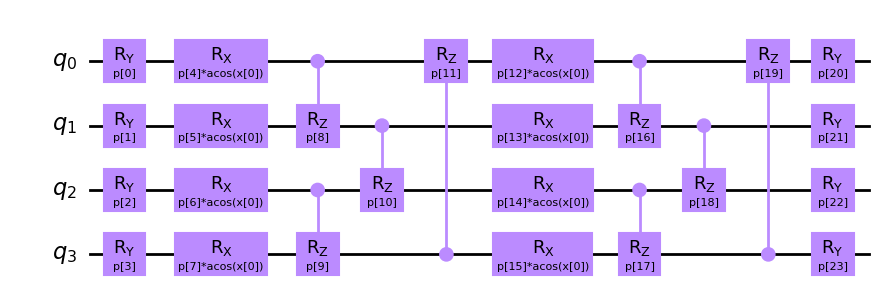

In [14]:
nqubits = 4
number_of_layers = 2

circuit = ChebyshevPQC(nqubits, 1, number_of_layers)
circuit.draw("mpl")

We also need an observable

In [15]:
observable = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(observable)
#Observables = SummedPaulis(nqubits, include_identity=False)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


We create the `ODELoss` function with the homogeneous differential equation

In [18]:
import sympy as sp
x = sp.symbols('x')
f, dfdx, dfdxdx = sp.symbols("f dfdx dfdxdx")
k = 1
eq = dfdx - sp.exp(-f*k) 
initial_vec = [np.log(0.1)]

In [19]:
loss_ODE = ODELoss(eq, symbols_involved_in_ODE=[x,f,dfdx], initial_vec = initial_vec, boundary_handling="pinned", eta=1)

Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

In [20]:
param_obs = observable.generate_initial_parameters(seed=1)
param_ini = circuit.generate_initial_parameters(seed=1)

adam = Adam(options={"maxiter": 20, "tol": 0.00009, "lr":0.03})

ode_regressor = QNNRegressor(
    circuit,
    observable,
    executor,
    loss_ODE,
    adam,
    param_ini,
    param_obs,
    opt_param_op = True, #Parametrized Observables not benchmarked yet
)


## Training

Now we are ready to train the model to fit the logarithm funciton

In [21]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.zeros_like(x_space)

ode_regressor.fit(x_space, ref_values)

fit:  15%|█▌        | 3/20 [00:21<02:05,  7.38s/it]32.20831716454448


## Evaluation

Let's check the trained parameters of the PQC and operator

In [12]:
print("Result PQC params:", ode_regressor.param)
print("Result operator params:", ode_regressor.param_op)

Result PQC params: [-0.21737442  1.54459045 -3.078744   -1.50991661 -0.33096189  1.69297355
  2.45536247  4.16816733 -1.20640027  0.65449674 -1.3524511   2.25891222
 -0.08859718  1.26163055  2.45162012  3.96836117 -0.90037446  0.99331429
 -4.85107776 -4.30172212  1.99215599  3.11412051 -1.53989064  0.93338716]
Result operator params: [1. 1. 1.]


Also let's plot the predicted function vs. the actual logarithm function

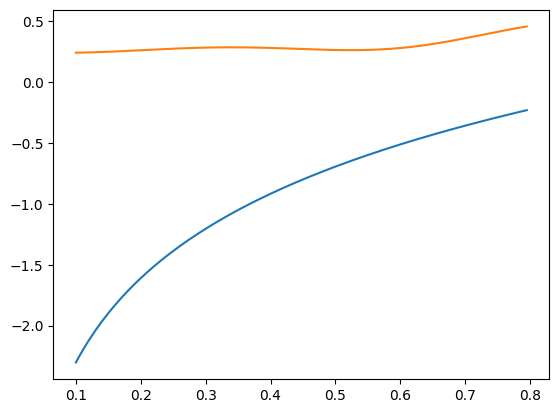

In [13]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = ode_regressor.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

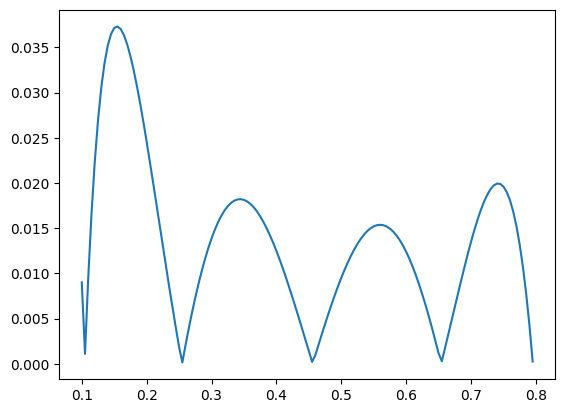

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

## Evaluation on noisy simulator

Finally let's evaluate the trained `QNNRegressor` with finite sampling noise.

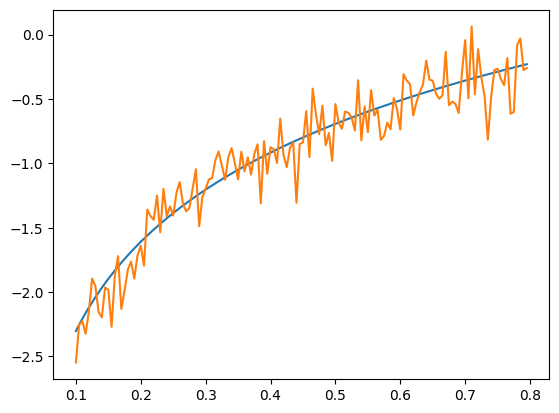

In [10]:
executor.set_shots(4000)
y = qnn.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

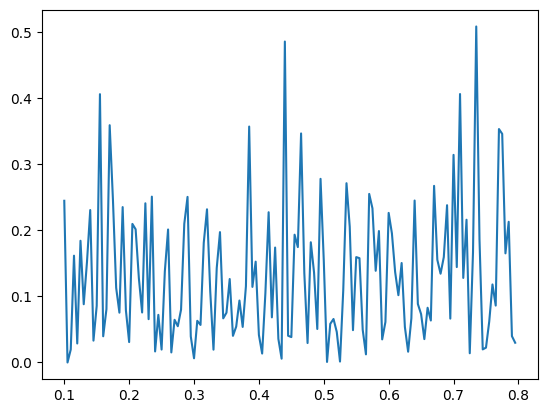

In [11]:
plt.plot(x, np.abs(y - np.log(x)))

We see, that the model is now subject to noise.